In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import keras 
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import cv2
import re
import random
random.seed(0)
np.random.seed(0)

# Plotting some images

Text(0.5, 1.0, 'wheat')

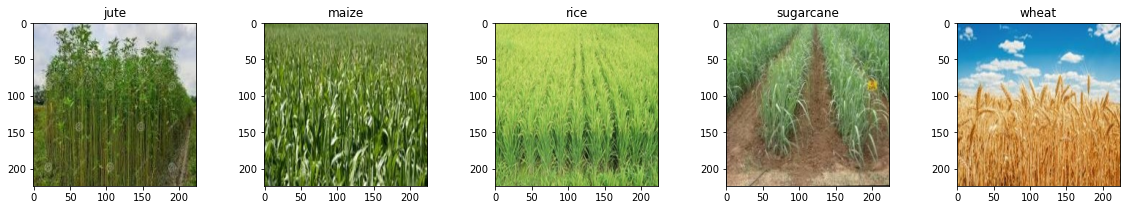

In [2]:
wheat = plt.imread(r"D:\kag2\wheat\wheat0004a.jpeg")
jute = plt.imread(r"D:\kag2\jute\jute005a.jpeg")
cane = plt.imread(r"D:\kag2\sugarcane\sugarcane0010arot.jpeg")
rice = plt.imread(r"D:\kag2\rice\rice032ahs.jpeg")
maize = plt.imread(r"D:\kag2\maize\maize003a.jpeg")
plt.figure(figsize=(20,3))
plt.subplot(1,5,1)
plt.imshow(jute)
plt.title("jute")
plt.subplot(1,5,2)
plt.imshow(maize)
plt.title("maize")
plt.subplot(1,5,3)
plt.imshow(rice)
plt.title("rice")
plt.subplot(1,5,4)
plt.imshow(cane)
plt.title("sugarcane")
plt.subplot(1,5,5)
plt.imshow(wheat)
plt.title("wheat")

# Converting to training and testing data

In [3]:
jutepath = os.path.join("D:\kag2","jute")
maizepath = os.path.join("D:\kag2","maize")
ricepath = os.path.join("D:\kag2","rice") 
sugarcanepath = os.path.join("D:\kag2","sugarcane")
wheatpath = os.path.join("D:\kag2","wheat")

jutefilename = os.listdir(jutepath)
maizefilename = os.listdir(maizepath)
ricefilename = os.listdir(ricepath)
sugarcanefilename = os.listdir(sugarcanepath)
wheatfilename = os.listdir(wheatpath)

X= []

In [4]:
for fname in jutefilename:
    X.append([os.path.join(jutepath,fname),0])
for fname in maizefilename:
    X.append([os.path.join(maizepath,fname),1])
for fname in ricefilename:
    X.append([os.path.join(ricepath,fname),2])
for fname in sugarcanefilename:
    X.append([os.path.join(sugarcanepath,fname),3]) 
for fname in wheatfilename:
    X.append([os.path.join(wheatpath,fname),4])  
X = pd.DataFrame(X,columns = ['path','labels'])    

In [5]:
X.head()

path  labels
0     D:\kag2\jute\jute001a.jpeg       0
1   D:\kag2\jute\jute001ahf.jpeg       0
2   D:\kag2\jute\jute001ahs.jpeg       0
3  D:\kag2\jute\jute001arot.jpeg       0
4     D:\kag2\jute\jute002a.jpeg       0

In [6]:
ohencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohlabel = pd.DataFrame(ohencoder.fit_transform(X[['labels']]),dtype = 'float64',columns = ['label0','label1','label2','label3','label4'])
label_X = X.copy()
X = pd.concat([X,ohlabel],axis = 1)
new_X = X.drop(['labels'],axis = 1)

In [7]:
train,test = train_test_split(new_X,test_size=0.2,random_state=0,shuffle = True,stratify=label_X['labels'])

In [8]:
X_train = train['path'].values
y_train = train.drop(['path'],axis=1).values
X_test = test['path'].values
y_test = test.drop(['path'],axis=1).values

In [9]:
def deep_pipeline(data):
    flat = []
    for i in data:
        img = plt.imread(i)
        img = img/255.
        flat.append(img)
    flat =  np.array(flat)    
    flat = flat.reshape(-1,224,224,3)       
    return flat
    

In [10]:
dx_train = deep_pipeline(X_train)
dx_test = deep_pipeline(X_test)

# Model training

In [26]:
keras.backend.clear_session()
vgg = keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg.trainable = False
vggmodel = keras.Sequential([vgg
                         ,Dense(500,activation='tanh'),Dense(500,activation='tanh'),Dense(5,activation='softmax')])

vggmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 500)               256500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
Total params: 20,533,889
Trainable params: 509,505
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
hist = vggmodel.fit(dx_train,y_train,epochs=40,validation_split=0.2,batch_size=32)

Epoch 1/40
17/17 [==============================] - 8s 450ms/step - loss: 2.0187 - accuracy: 0.2062 - val_loss: 1.6268 - val_accuracy: 0.3101
Epoch 2/40
17/17 [==============================] - 7s 436ms/step - loss: 1.4548 - accuracy: 0.4027 - val_loss: 1.3961 - val_accuracy: 0.3721
Epoch 3/40
17/17 [==============================] - ETA: 0s - loss: 1.2020 - accuracy: 0.4981

(0.0, 4.0)

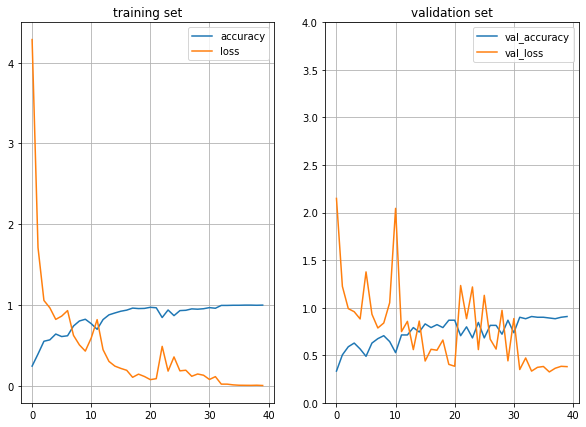

In [13]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
plt.legend()
plt.title("training set")
plt.grid()
plt.subplot(1,2,2)
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()
plt.title("validation set")
plt.grid()
plt.ylim((0,4))

# Test Score

In [14]:
score = vggmodel.evaluate(dx_test,y_test)
print("accuracy: ", score[1])

6/6 [==============================] - 2s 260ms/step - loss: 0.3719 - accuracy: 0.9255
accuracy:  0.9254658222198486


In [15]:
pred = vggmodel.predict(dx_test)
prediction = np.argmax(pred,axis=1)
true = np.argmax(y_test,axis=1)
best_prob = [pred[num,:][i] for num,i in enumerate(prediction)]

# Confusion Matrix

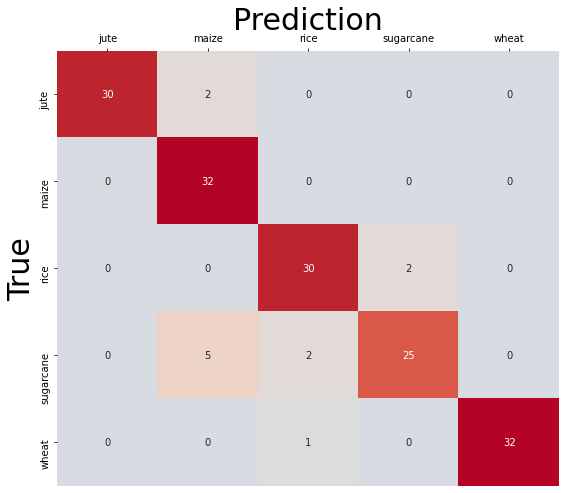

In [16]:
plt.figure(figsize = (9,8))
class_label = ['jute','maize','rice','sugarcane','wheat']
fig = sns.heatmap(confusion_matrix(true,prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label)
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

# Prediction Pipeline

In [17]:
def deepmodelpipeline(imagepath,model = vggmodel,label=[-1]):
    pdict = {0:"jute",1:"maize",2:"rice",3:"sugarcane",4:"wheat"}
    pred_x = deep_pipeline([imagepath])
    prediction = model.predict(pred_x)
    pred = np.argmax(prediction[0])
    plt.imshow(plt.imread(imagepath))
    if (label[0]!=-1):
        plt.title("prediction : {0} % {1:.2f} \ntrue        : {2}".format(pdict[pred],prediction[0,pred]*100,pdict[np.argmax(label)]))
    else:
        plt.title("prediction : {0}, % {1:.2f}".format(pdict[pred],prediction[0,pred]*100))

# Prediction on sample images

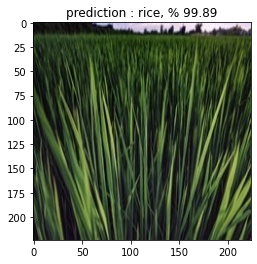

In [18]:
deepmodelpipeline(r'D:\kag2\rice\rice024ahs.jpeg')

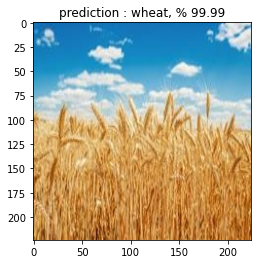

In [19]:
deepmodelpipeline(r'D:\kag2\wheat\wheat0004a.jpeg')

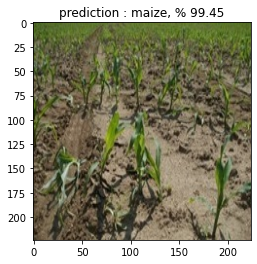

In [20]:
deepmodelpipeline(r"D:\kag2\maize\maize030a.jpeg")

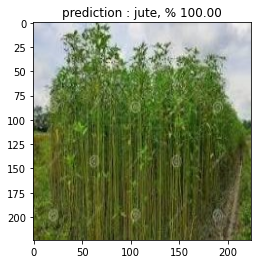

In [21]:
deepmodelpipeline(r"D:\kag2\jute\jute005a.jpeg")

# Prediction on test images

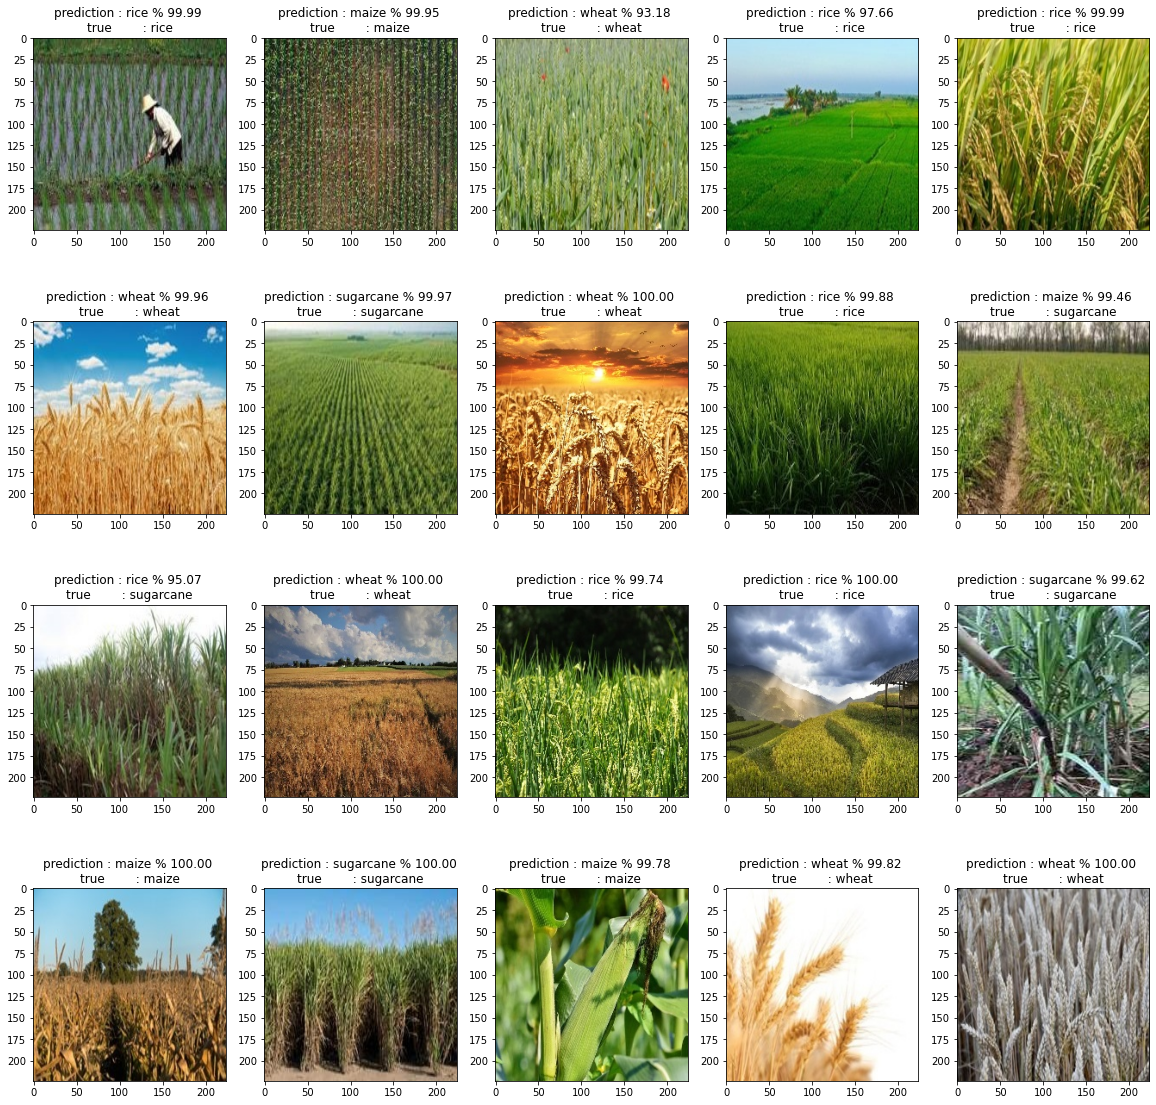

In [22]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X_test[0:20]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y_test[num])

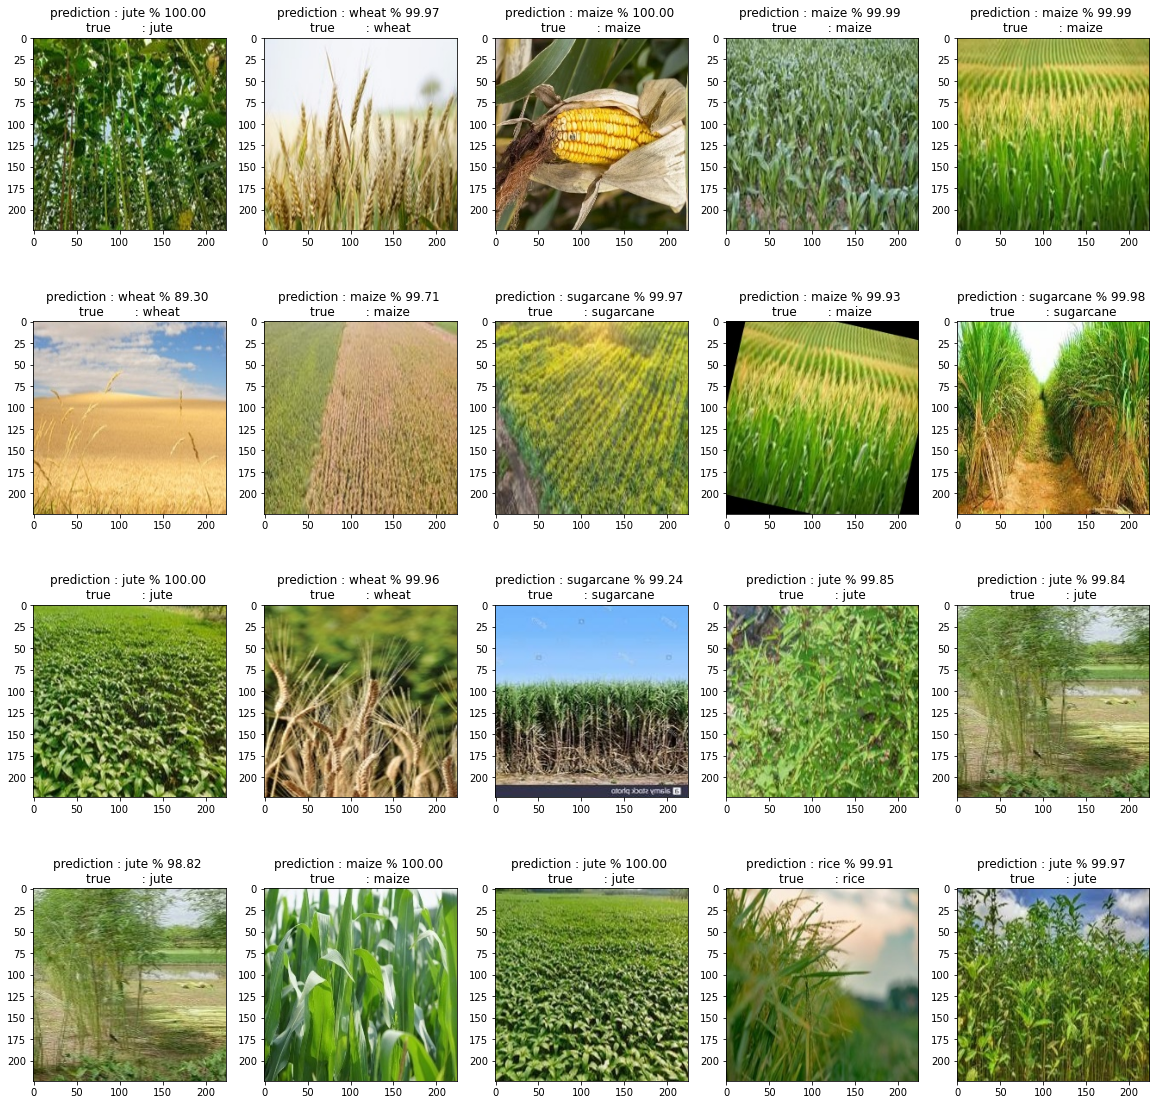

In [23]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X_test[20:40]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y_test[num+20])

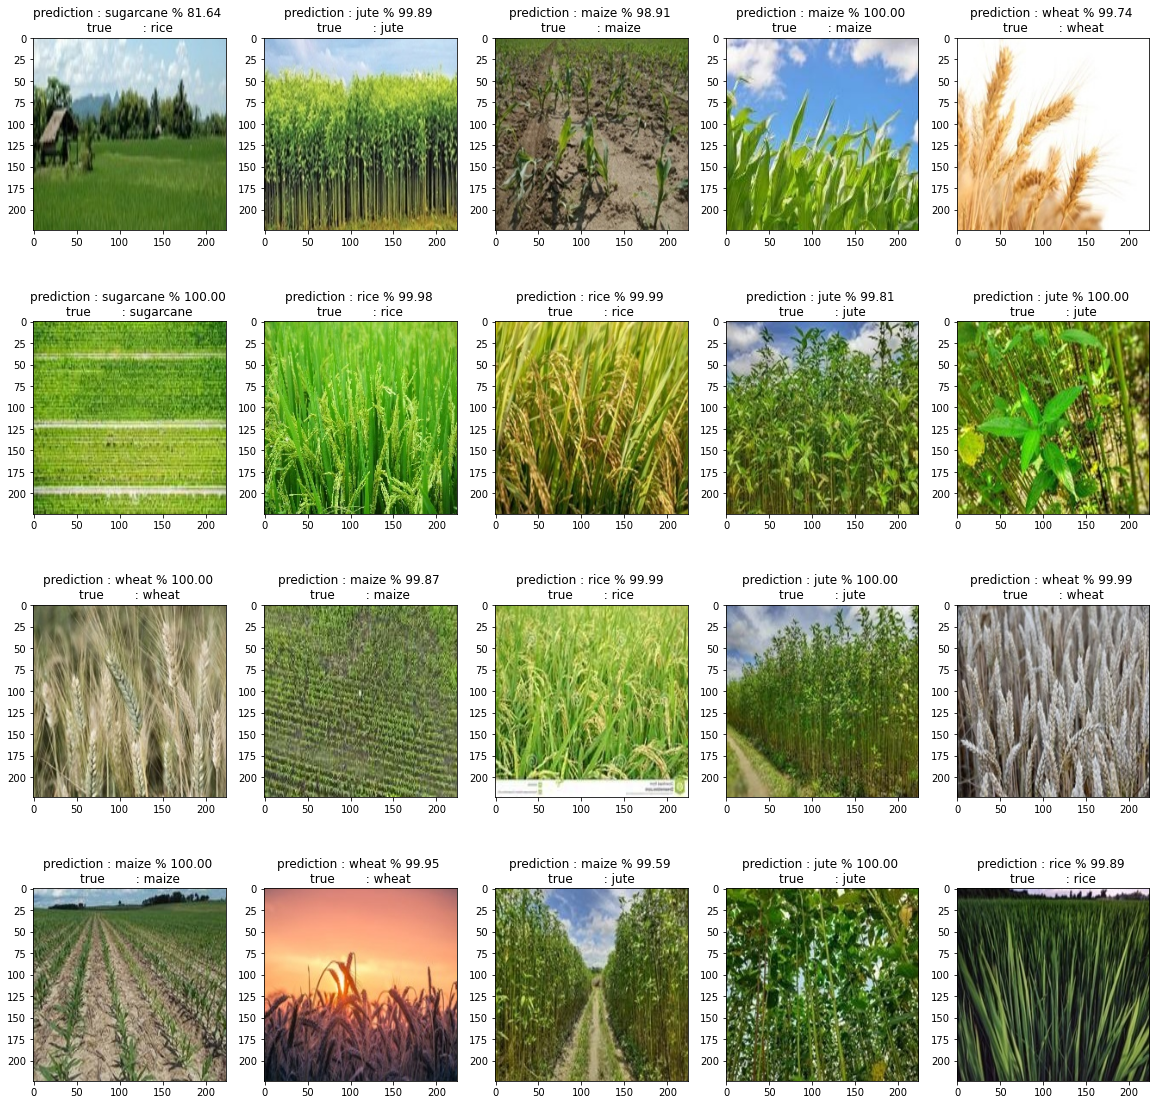

In [24]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X_test[40:60]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y_test[num+40])

# Saving model

In [25]:
vggmodel.save_weights("vggmodelweight.h5")